# 0. Dependências

In [1]:
import numpy as np
import pydotplus
from IPython.display import Image
from sklearn import tree

**Dependências:**
- conda install graphviz
- conda install -c conda-forge pydotplus

*Em caso de erro*: 
- *pip install graphviz*
- *adicionar a pasta "C:\Users\Arnaldo\Miniconda3\Library\bin\graphviz" ao path das variáveis de ambiente*

# 1. Introdução 

**Árvores de Decisão** são um dos algoritmos de Machine Learning mais fáceis de implementar. A ideia principla é dividir o problema em sub-problemas mais simples até que se resolva o problema. Nas árvores, cada **nó de decisão** contém um teste em um atributo, cada **folha** representa uma classe ou um valor (no caso da regressão) e o percurso da raiz até uma folha representa uma **regra de classificação/regressão**. Um atributo pode aparecer mais de uma vez na árvore, porém com valores diferentes. 

As **condições de paradas** podem ser inúmeras:
- Os atributos acabaram (no caso em que os atributos não se repetem na árvore)
- Todos os exemplos são de uma mesma classe
- A altura da árvore atingiu um valor previamente definido
- O número de exemplos a serem divididos é menor que um valor definido

**Vantagens:**
- Fáceis de entender e explicar. Mais fácil inclusive que regressão linear
- Algumas pessoas acreditam que ás arvores de decisão representam a tomada de decisão mais próxima dos seres humanos.
- Podem ser mostradas graficamente e facilmente interpretadas por não-especialistas
- Trabalha tanto com variáveis qualitativas e quantitativas sem precisar de pré-processamento

**Desvantagens:**
- A precisão não é tão boa quanto outros algoritmos
- Não são robustas. Uma pequena mudança nos dados pode causar uma grande diferença na árvore final.

**Algoritmo básico:**
1. Escolher um atributo
2. Dividir o (sub-)banco por uma valor específico do atributo
3. Para cada folha:
    
    3.1: Se todos os exemplos são da mesma classe, associar essa classe aos exemplos
    
    3.2: Caso contrário, repetir os passos 1 a 3
    
## Impureza e Ganho de Informação

*Como escolher o melhor atributo?* Existem muitas medidas e algoritmos diferentes:
- **ID3 e C4.5**: utilizam *ganho da informação*.
- **CART**: utiliza *impureza de Gini*.
- **CHAID**: utilizam significância estatística.

Em geral, todas as abordagens concordam em dois pontos:
- Uma divisão que mantém as proporções das classes é inútil
- Uma divisão onde todos os exemplos são da mesma classe, tem utilidade máxima

### Entropia
A **Entropia** caracteriza a impureza de uma coleção arbitrária de exemplos.

Seja $S$ uma amostra de exemplos e $p_i$ a probabilidade de cada classe $i$. A entropia $E(S)$ é definida como:

$$E(S) = \sum_i^n{p_i\ln{p_i}}$$

### Ganho de Informação

O **Ganho de Informação (GI)** é a diferença entre a impureza atual (entropia, gini, etc..) e a impureza ponderada dos dois novos grupos. Intuitivamente, o **GI representa a divisão que reduz a impureza, ou seja, obtém grupos mais homogêneos em comparação com o grupo antes da divisão**. Comparando o GI para várias divisões baseadas nas regras de divisão diferente nos permite escolher a "melhor" divisão.

# 2. Dados

In [2]:
x = np.array([
            ['Sol'    , 85, 85, 'Não'],
            ['Sol'    , 80, 90, 'Sim'],
            ['Nublado', 83, 86, 'Não'],
            ['Chuva'  , 70, 96, 'Não'],
            ['Chuva'  , 68, 80, 'Não'],
            ['Chuva'  , 65, 70, 'Sim'],
            ['Nublado', 64, 65, 'Sim'],
            ['Sol'    , 72, 95, 'Não'],
            ['Sol'    , 69, 70, 'Não'],
            ['Chuva'  , 75, 80, 'Não'],
            ['Sol'    , 75, 70, 'Sim'],
            ['Nublado', 72, 90, 'Sim'],
            ['Nublado', 81, 75, 'Não'],
            ['Chuva'  , 71, 91, 'Sim']
            ], dtype='object')

y = np.array(['Não', 'Não', 'Sim', 'Sim', 'Sim', 'Não', 'Sim', 'Não', 'Sim', 'Sim', 'Sim', 'Sim', 'Sim', 'Não']).reshape(-1, 1)

print(x.shape, y.shape)

(14, 4) (14, 1)


# 3. Implementação 

In [3]:
def most_frequent_class(y):
    classes, class_counts = np.unique(y, return_counts=True)
    return classes[np.argmax(class_counts)]

def entropy(y):
    if len(y) == 0: 
        return 0.0

    _, class_counts = np.unique(y, return_counts=True)
    proportions = class_counts / y.shape[0]
    return -np.sum(proportions * np.log2(proportions))

def gini(y):
    if len(y) == 0: return 0.0

    _, class_counts = np.unique(y, return_counts=True)
    proportions = class_counts / y.shape[0]
    return 1.0 - np.sum(proportions**2)

In [4]:
class Node():
    def __init__(self, parent=None):
        self.parent = parent
        self.left_child = None   # less than a value (regression) OR not equal to a category (classification)
        self.right_child = None  # otherwise
        self.col_index = None
        self.value = None
        self.is_leaf = True
        self.output = None

class DecisionTree():
    def __init__(self, criterion=gini, max_depth=None, min_samples_split=2, is_classification=True):
        self.criterion = criterion
        self.max_depth = np.inf if max_depth is None else max_depth
        self.min_samples_split = min_samples_split
        self.is_classification = is_classification
        self.root = Node()

    def fit(self, x, y):
        self.__build_tree(self.root, x, y)

    def predict(self, x):
        return np.array([self.__compute_output(sample, self.root) for sample in x])

    def __build_tree(self, parent_node, x, y, depth=0):
        parent_node.col_index, parent_node.value, best_gain = self.__find_best_split(x, y)
        if best_gain == 0.0 or depth > self.max_depth: 
            parent_node.output = most_frequent_class(y) if self.is_classification else np.mean(y)
            return

        left_child = Node(parent=parent_node)
        right_child = Node(parent=parent_node)
        parent_node.is_leaf = False

        x_left, y_left, x_right, y_right = self.__split_data_by_value(x, y, parent_node.col_index, parent_node.value)

        if len(x_left) >= self.min_samples_split:
            self.__build_tree(left_child, x_left, y_left, depth + 1)
        else:
            left_child.output = most_frequent_class(y_left) if self.is_classification else np.mean(y_left)

        if len(x_right) >= self.min_samples_split:
            self.__build_tree(right_child, x_right, y_right, depth + 1)
        else:
            right_child.output = most_frequent_class(y_right) if self.is_classification else np.mean(y_right)

        parent_node.left_child = left_child
        parent_node.right_child = right_child


    def __find_best_split(self, x, y):
        best_gain, best_col, best_value = 0.0, None, None
        current_impurity = self.criterion(y)
        
        n_atts = x.shape[1]
        for att in range(n_atts):
            att_values = np.unique(x[:, att])
            for value in att_values:
                _, y_left, _, y_right = self.__split_data_by_value(x, y, att, value)
                
                left_impurity = self.criterion(y_left)
                right_impurity = self.criterion(y_right)
                p = len(y_left) / y.shape[0]

                gain = current_impurity - (p * left_impurity + (1 - p) * right_impurity)
                if gain > best_gain:
                    best_gain = gain
                    best_col = att
                    best_value = value

        return best_col, best_value, best_gain

    def __split_data_by_value(self, x, y, col_index, value):
        left_mask = x[:, col_index] < value
        right_mask = np.invert(left_mask)
        return x[left_mask], y[left_mask], x[right_mask], y[right_mask]

    def __compute_output(self, x, node):
        if node.is_leaf: return node.output
        
        is_discrete = isinstance(node.value, str)
        right_condition = x[node.col_index] == node.value if is_discrete else x[node.col_index] > node.value
        return self.__compute_output(x, node.right_child if right_condition else node.left_child)

    def __str__(self):
        return self.__print_tree(self.root)

    def __print_tree(self, node, indent=''):
        if node.is_leaf: return 'Leaf: y = {}\n'.format(node.output)

        is_discrete = isinstance(node.value, str)
        right_condition = 'x[{}] {} {} | '.format(node.col_index, '==' if is_discrete else '>=', node.value)
        left_condition = indent
        left_condition += 'x[{}] {} {} | '.format(node.col_index, '!=' if is_discrete else '< ', node.value)        
        
        summary = right_condition + self.__print_tree(node.right_child, indent + ' '*len(right_condition))
        summary += left_condition + self.__print_tree(node.left_child, indent + ' '*len(right_condition))
                
        return summary

# 4. Teste 

In [5]:
x = np.array([
            ['Sol'    , 85, 85, 'Não'],
            ['Sol'    , 80, 90, 'Sim'],
            ['Nublado', 83, 86, 'Não'],
            ['Chuva'  , 70, 96, 'Não'],
            ['Chuva'  , 68, 80, 'Não'],
            ['Chuva'  , 65, 70, 'Sim'],
            ['Nublado', 64, 65, 'Sim'],
            ['Sol'    , 72, 95, 'Não'],
            ['Sol'    , 69, 70, 'Não'],
            ['Chuva'  , 75, 80, 'Não'],
            ['Sol'    , 75, 70, 'Sim'],
            ['Nublado', 72, 90, 'Sim'],
            ['Nublado', 81, 75, 'Não'],
            ['Chuva'  , 71, 91, 'Sim']
            ], dtype='object')

y = np.array(['Não', 'Não', 'Sim', 'Sim', 'Sim', 'Não', 'Sim', 'Não', 'Sim', 'Sim', 'Sim', 'Sim', 'Sim', 'Não']).reshape(-1, 1)

dt = DecisionTree()
dt.fit(x, y)

print(dt)

x[2] >= 85 | x[0] == Sol | Leaf: y = Não
             x[0] != Sol | x[0] == Nublado | Leaf: y = Sim
                           x[0] != Nublado | x[1] >= 71 | Leaf: y = Não
                                             x[1] <  71 | Leaf: y = Sim
x[2] <  85 | x[1] >= 68 | Leaf: y = Sim
             x[1] <  68 | x[0] == Nublado | Leaf: y = Sim
                          x[0] != Nublado | Leaf: y = Não



In [6]:
dt.predict([['Chuva', 70, 90, 'Não']])

array(['Sim'], 
      dtype='<U3')

### Comparação com o Scikit-learn

In [7]:
x = np.array([
            [0, 85, 85, 0],
            [0, 80, 90, 1],
            [1, 83, 86, 0],
            [2, 70, 96, 0],
            [2, 68, 80, 0],
            [2, 65, 70, 1],
            [1, 64, 65, 1],
            [0, 72, 95, 0],
            [0, 69, 70, 0],
            [2, 75, 80, 0],
            [0, 75, 70, 1],
            [1, 72, 90, 1],
            [1, 81, 75, 0],
            [2, 71, 91, 1]
            ])

y = np.array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0]).reshape(-1, 1)

clf = tree.DecisionTreeClassifier(criterion='gini')
clf.fit(x, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

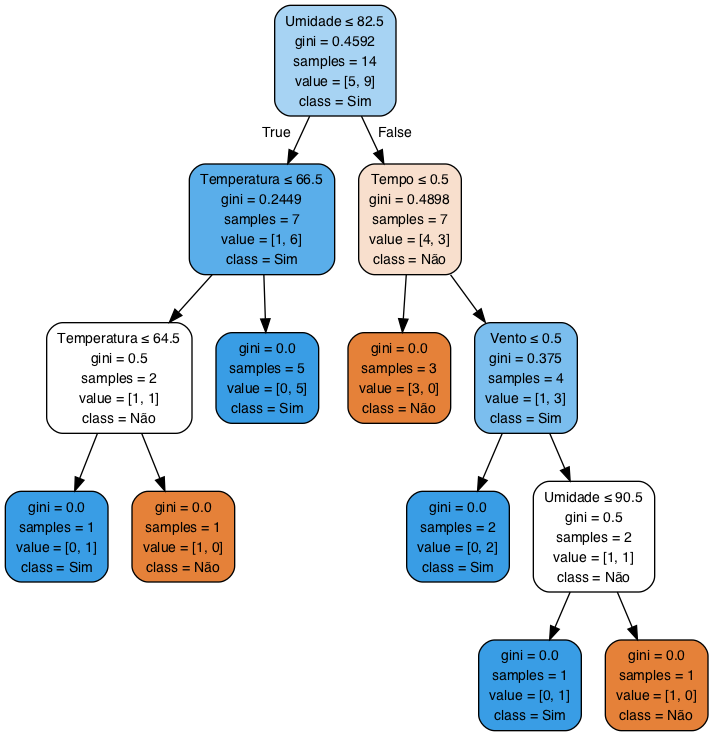

In [8]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=['Tempo', 'Temperatura', 'Umidade', 'Vento'], 
                                class_names=['Não', 'Sim'],
                                filled=True, rounded=True,
                                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

## 5. Referências